In [1]:
# seeds = [0, 1, 2, 3, 4, 1458, 663, 1955, 7130, 1708]
seed = 2

## Imports

In [2]:
from __future__ import division,print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib.pyplot as plt
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable, grad
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter
import os
import calculate_log_v2 as callog
from test_utils import *
import warnings
warnings.filterwarnings('ignore')
torch.set_num_threads(1)

In [3]:
# torch.cuda.set_device(2) #Select the GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
aurocs = []
tnrs = []
dtaccs = []
auins = []
auouts = []

## Model definition

In [5]:
import torch
from torch import Tensor
import torch.nn as nn
# from .utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        collect_option: bool = False,
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        
        self.collect_option = collect_option

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        t = self.conv1(x)
        out = self.bn1(t)
        out = self.relu(out)
        if self.collect_option:
            torch_model.record(t)
            torch_model.record(out)

        t = self.conv2(out)
        out = self.bn2(t)
        if self.collect_option:
            torch_model.record(t)
            torch_model.record(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        if self.collect_option:
            torch_model.record(identity)
        out = self.relu(out)
        if self.collect_option:
            torch_model.record(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], collect_option = False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0], collect_option = False)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1], collect_option = False)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2], collect_option = False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=128, bias=True),  # 0
            nn.ReLU(),
        )
        self.fc_last = nn.Sequential(
#             Lambda(lambda x: torch_model.record(x)),
            nn.Linear(in_features=128, out_features=2, bias=True),  # 3
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
                    
        self.collecting = False

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False, collect_option: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, collect_option))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, collect_option=collect_option))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        torch_model.record(x)
        x = self.fc_last(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    """
        add for gram matrix
    """
    def record(self, t):
        if self.collecting:
            self.gram_feats.append(t)
    
    def gram_feature_list(self,x):
        self.collecting = True
        self.gram_feats = []
        self.forward(x)
        self.collecting = False
        temp = self.gram_feats
        self.gram_feats = []
        return temp
    
    def load(self, path="resnet_cifar10.pth"):
        tm = torch.load(path,map_location="cpu")    
        tm['fc_last.0.weight'] = tm['fc.2.weight']
        tm['fc_last.0.bias'] = tm['fc.2.bias']
        del tm['fc.2.weight']
        del tm['fc.2.bias']
#         print(tm['fc.2.weight'])
#         print(tm['fc.2.bias'])
        self.load_state_dict(tm)
    
    def get_min_max(self, data, power):
        mins = []
        maxs = []
        
        for i in range(0,len(data),32):
            batch = data[i:i+32].cuda()
            feat_list = self.gram_feature_list(batch)
            for L,feat_L in enumerate(feat_list):
                if L==len(mins):
                    mins.append([None]*len(power))
                    maxs.append([None]*len(power))
                
                for p,P in enumerate(power):
                    g_p = G_p(feat_L,P)
                    
                    current_min = g_p.min(dim=0,keepdim=True)[0]
                    current_max = g_p.max(dim=0,keepdim=True)[0]
                    
                    if mins[L][p] is None:
                        mins[L][p] = current_min
                        maxs[L][p] = current_max
                    else:
                        mins[L][p] = torch.min(current_min,mins[L][p])
                        maxs[L][p] = torch.max(current_max,maxs[L][p])
        
        return mins,maxs
    
    def get_deviations(self,data,power,mins,maxs):
        deviations = []
        
        for i in range(0,len(data),32):            
            batch = data[i:i+32].cuda()
            feat_list = self.gram_feature_list(batch)
            batch_deviations = []
            for L,feat_L in enumerate(feat_list):
                dev = 0
                for p,P in enumerate(power):
                    g_p = G_p(feat_L,P)
                    
                    dev +=  (F.relu(mins[L][p]-g_p)/torch.abs(mins[L][p]+10**-6)).sum(dim=1,keepdim=True)
                    dev +=  (F.relu(g_p-maxs[L][p])/torch.abs(maxs[L][p]+10**-6)).sum(dim=1,keepdim=True)
                batch_deviations.append(dev.cpu().detach().numpy())
            batch_deviations = np.concatenate(batch_deviations,axis=1)
            deviations.append(batch_deviations)
        deviations = np.concatenate(deviations,axis=0)
        
        return deviations

def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [6]:
torch_model = resnet18()
torch_model.load(path = "../results/models/best_{}.pt".format(seed))
torch_model.cuda()
torch_model.params = list(torch_model.parameters())
torch_model.eval()
print("Done")

Done


## Datasets

<b>In-distribution Datasets</b>

In [7]:
from utils import *
from dataset import *

In [8]:
bones_df, train_df, val_df, test_df, data_transform = Data_Transform("/home/data_storage/ood_datasets/data/datasets/boneage_data_kaggle/")
############# Call dataset class #############
train_dataset = BoneDataset(dataframe = train_df,img_dir='/home/data_storage/ood_datasets/data/datasets/boneage_data_kaggle/boneage-training-dataset/boneage-training-dataset/', mode = 'train', transform = data_transform)
test_dataset = BoneDataset(dataframe = test_df,img_dir='/home/data_storage/ood_datasets/data/datasets/boneage_data_kaggle/boneage-training-dataset/boneage-training-dataset/', mode = 'test', transform = data_transform)

avg_mean, avg_std, age_min, age_max 46.49 42.56 1.0 228.0
males and females 4477 5334
males and females 4477 4477
males and females 673 727
males and females 673 673


In [9]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

data_train = list(torch.utils.data.DataLoader( train_dataset, batch_size=1, shuffle=False))
data = list(torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False))

In [10]:
# def get_features_hook(self, input, output):
#     torch_model.record(input)

# # def get_features(model, data, num_classes, device=None):
# #     '''
# #     Compute the proposed Mahalanobis confidence score on input dataset
# #     return: Mahalanobis score from layer_index
# #     '''
# #     model.eval()
# #     handle = model.fc[2].register_forward_hook(get_features_hook)
# #     model(data)
# #     handle.remove()

In [11]:
torch_model.eval()
# handle = torch_model.fc[2].register_forward_hook(get_features_hook)
correct = 0
total = 0
for x,y in test_loader:
    x = x.cuda()
    y = y.squeeze().numpy()
    ans = (y==np.argmax(torch_model(x).detach().cpu().numpy(),axis=1)).sum()
    correct += ans
    total += y.shape[0]
print("Accuracy: ",correct/total)
# handle.remove()

Accuracy:  0.9227340267459139


<b>Out-of-distribution Datasets</b>

In [12]:
# from dataset import get_eval_200_dataloaders

In [13]:

images_dir = os.path.join("/home/data_storage/ood_datasets/data/datasets/boneage_data_kaggle/", 'boneage-training-dataset/boneage-training-dataset/')
loaders, data_len, _   = get_adjust_dataloaders(bones_df, train_df, val_df, test_df, images_dir, data_transform, 'bright')

males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and females 673 727
males and females 673 673
males and fe

In [14]:
loaders

## Code for Detecting OODs

<b> Extract predictions for train and test data </b>

In [15]:
train_preds = []
train_confs = []
train_logits = []
for idx in range(0,len(data_train),32):
    batch = torch.squeeze(torch.stack([x[0] for x in data_train[idx:idx+32]]),dim=1).cuda()
#     handle = torch_model.fc[2].register_forward_hook(get_features_hook)
    logits = torch_model(batch)
#     handle.remove()
    confs = F.softmax(logits,dim=1).cpu().detach().numpy()
    preds = np.argmax(confs,axis=1)
    logits = (logits.cpu().detach().numpy())

    train_confs.extend(np.max(confs,axis=1))    
    train_preds.extend(preds)
    train_logits.extend(logits)
print("Done")

test_preds = []
test_confs = []
test_logits = []

for idx in range(0,len(data),32):
    batch = torch.squeeze(torch.stack([x[0] for x in data[idx:idx+32]]),dim=1).cuda()
#     handle = torch_model.fc[2].register_forward_hook(get_features_hook)
    logits = torch_model(batch)
#     handle.remove()
    confs = F.softmax(logits,dim=1).cpu().detach().numpy()
    preds = np.argmax(confs,axis=1)
    logits = (logits.cpu().detach().numpy())

    test_confs.extend(np.max(confs,axis=1))    
    test_preds.extend(preds)
    test_logits.extend(logits)
print("Done")

Done
Done


<b> Code for detecting OODs by identifying anomalies in correlations </b>

In [16]:
import calculate_log_v2 as callog

def detect(all_test_deviations,all_ood_deviations, verbose=True, normalize=True):
    average_results = {}
    for i in range(1,11):
        random.seed(i)
        
        validation_indices = random.sample(range(len(all_test_deviations)),int(0.1*len(all_test_deviations)))
        test_indices = sorted(list(set(range(len(all_test_deviations)))-set(validation_indices)))

        validation = all_test_deviations[validation_indices]
        test_deviations = all_test_deviations[test_indices]

        t95 = validation.mean(axis=0)+10**-7
        if not normalize:
            t95 = np.ones_like(t95)
        test_deviations = (test_deviations/t95[np.newaxis,:]).sum(axis=1)
        ood_deviations = (all_ood_deviations/t95[np.newaxis,:]).sum(axis=1)
        
#         print("test:", test_deviations.shape)
#         print("ood:", ood_deviations.shape)
        results = callog.compute_metric(-test_deviations,-ood_deviations)
        for m in results:
            average_results[m] = average_results.get(m,0)+results[m]
    
    for m in average_results:
        average_results[m] /= i
#     if verbose:
# #         aurocs.append(callog.print_results(average_results))
    auroc, tnr, dtacc, auin, auout = callog.print_results(average_results)
    aurocs.append(auroc)
    tnrs.append(tnr)
    dtaccs.append(dtacc)
    auins.append(auin)
    auouts.append(auout)
    
    return average_results

def cpu(ob):
    for i in range(len(ob)):
        for j in range(len(ob[i])):
            ob[i][j] = ob[i][j].cpu()
    return ob

def cuda(ob):
    for i in range(len(ob)):
        for j in range(len(ob[i])):
            ob[i][j] = ob[i][j].cuda()
    return ob

class Detector:
    def __init__(self):
        self.all_test_deviations = None
        self.mins = {}
        self.maxs = {}
        
        self.classes = range(2)
    
    def compute_minmaxs(self,data_train,POWERS=[10]):
        for PRED in tqdm(self.classes):
            train_indices = np.where(np.array(train_preds)==PRED)[0]
            train_PRED = torch.squeeze(torch.stack([data_train[i][0] for i in train_indices]),dim=1)
            mins,maxs = torch_model.get_min_max(train_PRED,power=POWERS)
            self.mins[PRED] = cpu(mins)
            self.maxs[PRED] = cpu(maxs)
            torch.cuda.empty_cache()
    
    def compute_test_deviations(self,POWERS=[10]):
        all_test_deviations = None
        test_classes = []
        for PRED in tqdm(self.classes):
            test_indices = np.where(np.array(test_preds)==PRED)[0]
            test_PRED = torch.squeeze(torch.stack([data[i][0] for i in test_indices]),dim=1)
            test_confs_PRED = np.array([test_confs[i] for i in test_indices])
            
            test_classes.extend([PRED]*len(test_indices))
            
            mins = cuda(self.mins[PRED])
            maxs = cuda(self.maxs[PRED])
            test_deviations = torch_model.get_deviations(test_PRED,power=POWERS,mins=mins,maxs=maxs)/test_confs_PRED[:,np.newaxis]
            cpu(mins)
            cpu(maxs)
            if all_test_deviations is None:
                all_test_deviations = test_deviations
            else:
                all_test_deviations = np.concatenate([all_test_deviations,test_deviations],axis=0)
            torch.cuda.empty_cache()
        self.all_test_deviations = all_test_deviations
        self.test_classes = np.array(test_classes)
    
    def compute_ood_deviations(self,logger, ood,adjust_scale,POWERS=[10]):
        ood_preds = []
        ood_confs = []
        
        for idx in range(0,len(ood),32):
            batch = torch.squeeze(torch.stack([x[0] for x in ood[idx:idx+32]]),dim=1).cuda()
            logits = torch_model(batch)
            confs = F.softmax(logits,dim=1).cpu().detach().numpy()
            preds = np.argmax(confs,axis=1)
            
            ood_confs.extend(np.max(confs,axis=1))
            ood_preds.extend(preds)  
            torch.cuda.empty_cache()
        print("Done")
        
        ood_classes = []
        all_ood_deviations = None
        for PRED in tqdm(self.classes):
            ood_indices = np.where(np.array(ood_preds)==PRED)[0]
            if len(ood_indices)==0:
                continue
            ood_classes.extend([PRED]*len(ood_indices))
            
            ood_PRED = torch.squeeze(torch.stack([ood[i][0] for i in ood_indices]),dim=1)
            ood_confs_PRED =  np.array([ood_confs[i] for i in ood_indices])
            mins = cuda(self.mins[PRED])
            maxs = cuda(self.maxs[PRED])
            ood_deviations = torch_model.get_deviations(ood_PRED,power=POWERS,mins=mins,maxs=maxs)/ood_confs_PRED[:,np.newaxis]
            cpu(self.mins[PRED])
            cpu(self.maxs[PRED])            
            if all_ood_deviations is None:
                all_ood_deviations = ood_deviations
            else:
                all_ood_deviations = np.concatenate([all_ood_deviations,ood_deviations],axis=0)
            torch.cuda.empty_cache()
            
        self.ood_classes = np.array(ood_classes)
        
        auroc, aupr_in, aupr_out, fpr95 = get_measures(-self.all_test_deviations, -all_ood_deviations)
        path_auroc_aupr = os.path.join(f"results/logs/lastlayer/ood_scores/NAS_DETECTION_bright_test_Gram/seed_{seed}", str(adjust_scale))
        os.makedirs(path_auroc_aupr, exist_ok =True)
        auc_roc, auc_aupr_in, auc_aupr_out = plot_aupr_auroc(-self.all_test_deviations, -all_ood_deviations, path_auroc_aupr)

        logger.info("Running test...")
        logger.flush()
        logger.info('============Results for gram ============')
        logger.info('AUROC: {}'.format(auroc))
        logger.info('AUPR (In): {}'.format(aupr_in))
        logger.info('AUPR (Out): {}'.format(aupr_out))
        logger.info('FPR95: {}'.format(fpr95))
        logger.info('Recalculating AUROC using sk.auc: {}'.format(auc_roc))
        logger.info('Recalculating AUPR (In) using sk.auc: {}'.format(auc_aupr_in))
        logger.info('Recalculating AUPR (Out) using sk.auc: {}'.format(auc_aupr_out))

        logger.flush()
    
        # average_results = detect(self.all_test_deviations,all_ood_deviations)
        # return average_results, self.all_test_deviations, all_ood_deviations


<center><h1> Results </h1></center>


-------------------------
IDX:  0
Done



auc roc 0.4999997240185548
auc aupr in 0.683506612509712
auc aupr out 0.5001847093495768


2022-08-15 12:53:21,720 [INFO] log: Running test...
2022-08-15 12:53:21,723 [INFO] log: ============Results for gram ============
2022-08-15 12:53:21,724 [INFO] log: AUROC: 0.4999997240185548
2022-08-15 12:53:21,725 [INFO] log: AUPR (In): 0.5
2022-08-15 12:53:21,725 [INFO] log: AUPR (Out): 0.5
2022-08-15 12:53:21,726 [INFO] log: FPR95: 0.950222882615156
2022-08-15 12:53:21,726 [INFO] log: Recalculating AUROC using sk.auc: 0.4999997240185548
2022-08-15 12:53:21,727 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.683506612509712
2022-08-15 12:53:21,727 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5001847093495768


-------------------------
IDX:  1
Done



auc roc 0.937592867756315
auc aupr in 0.9682992315292482
auc aupr out 0.4815579769068141


2022-08-15 12:55:06,853 [INFO] log: Running test...
2022-08-15 12:55:06,854 [INFO] log: ============Results for gram ============
2022-08-15 12:55:06,855 [INFO] log: AUROC: 0.937592867756315
2022-08-15 12:55:06,855 [INFO] log: AUPR (In): 0.9683052138080293
2022-08-15 12:55:06,856 [INFO] log: AUPR (Out): 0.9398946953043501
2022-08-15 12:55:06,857 [INFO] log: FPR95: 1.0
2022-08-15 12:55:06,857 [INFO] log: Recalculating AUROC using sk.auc: 0.937592867756315
2022-08-15 12:55:06,858 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.9682992315292482
2022-08-15 12:55:06,859 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.4815579769068141


-------------------------
IDX:  2
Done



auc roc 0.8018778881458242
auc aupr in 0.8361238433493333
auc aupr out 0.7828603838068444


2022-08-15 12:56:46,443 [INFO] log: Running test...
2022-08-15 12:56:46,444 [INFO] log: ============Results for gram ============
2022-08-15 12:56:46,444 [INFO] log: AUROC: 0.8018778881458242
2022-08-15 12:56:46,445 [INFO] log: AUPR (In): 0.7629836359053446
2022-08-15 12:56:46,446 [INFO] log: AUPR (Out): 0.759906192955867
2022-08-15 12:56:46,446 [INFO] log: FPR95: 0.7540861812778603
2022-08-15 12:56:46,447 [INFO] log: Recalculating AUROC using sk.auc: 0.8018778881458242
2022-08-15 12:56:46,447 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8361238433493333
2022-08-15 12:56:46,448 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.7828603838068444


-------------------------
IDX:  3
Done



auc roc 0.5924278418913339
auc aupr in 0.7175744317619384
auc aupr out 0.6017989477204371


2022-08-15 12:58:25,887 [INFO] log: Running test...
2022-08-15 12:58:25,887 [INFO] log: ============Results for gram ============
2022-08-15 12:58:25,888 [INFO] log: AUROC: 0.5924278418913339
2022-08-15 12:58:25,889 [INFO] log: AUPR (In): 0.5585076882017254
2022-08-15 12:58:25,890 [INFO] log: AUPR (Out): 0.5678979749970566
2022-08-15 12:58:25,891 [INFO] log: FPR95: 0.8974739970282318
2022-08-15 12:58:25,891 [INFO] log: Recalculating AUROC using sk.auc: 0.5924278418913339
2022-08-15 12:58:25,892 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7175744317619384
2022-08-15 12:58:25,892 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.6017989477204371


-------------------------
IDX:  4
Done



auc roc 0.566363602242294
auc aupr in 0.7072465717820742
auc aupr out 0.5753251855121633


2022-08-15 13:00:04,773 [INFO] log: Running test...
2022-08-15 13:00:04,774 [INFO] log: ============Results for gram ============
2022-08-15 13:00:04,775 [INFO] log: AUROC: 0.566363602242294
2022-08-15 13:00:04,776 [INFO] log: AUPR (In): 0.5411533512757923
2022-08-15 13:00:04,776 [INFO] log: AUPR (Out): 0.5465977804569271
2022-08-15 13:00:04,777 [INFO] log: FPR95: 0.9078751857355126
2022-08-15 13:00:04,778 [INFO] log: Recalculating AUROC using sk.auc: 0.566363602242294
2022-08-15 13:00:04,778 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7072465717820742
2022-08-15 13:00:04,779 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5753251855121633


-------------------------
IDX:  5
Done



auc roc 0.5414695239209677
auc aupr in 0.6977856126356851
auc aupr out 0.5517219134228073


2022-08-15 13:01:43,815 [INFO] log: Running test...
2022-08-15 13:01:43,817 [INFO] log: ============Results for gram ============
2022-08-15 13:01:43,817 [INFO] log: AUROC: 0.5414695239209677
2022-08-15 13:01:43,818 [INFO] log: AUPR (In): 0.5242956918358684
2022-08-15 13:01:43,819 [INFO] log: AUPR (Out): 0.5317293687975148
2022-08-15 13:01:43,819 [INFO] log: FPR95: 0.9234769687964339
2022-08-15 13:01:43,820 [INFO] log: Recalculating AUROC using sk.auc: 0.5414695239209677
2022-08-15 13:01:43,821 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6977856126356851
2022-08-15 13:01:43,822 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5517219134228073


-------------------------
IDX:  6
Done



auc roc 0.5297292732415013
auc aupr in 0.6936907715084639
auc aupr out 0.5320742428012818


2022-08-15 13:03:24,188 [INFO] log: Running test...
2022-08-15 13:03:24,189 [INFO] log: ============Results for gram ============
2022-08-15 13:03:24,189 [INFO] log: AUROC: 0.5297292732415013
2022-08-15 13:03:24,190 [INFO] log: AUPR (In): 0.51765354800605
2022-08-15 13:03:24,191 [INFO] log: AUPR (Out): 0.5163187946675579
2022-08-15 13:03:24,192 [INFO] log: FPR95: 0.9427934621099554
2022-08-15 13:03:24,192 [INFO] log: Recalculating AUROC using sk.auc: 0.5297292732415013
2022-08-15 13:03:24,193 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6936907715084639
2022-08-15 13:03:24,193 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5320742428012818


-------------------------
IDX:  7
Done



auc roc 0.5216087951974813
auc aupr in 0.6907834380525111
auc aupr out 0.523933624459891


2022-08-15 13:05:03,314 [INFO] log: Running test...
2022-08-15 13:05:03,315 [INFO] log: ============Results for gram ============
2022-08-15 13:05:03,315 [INFO] log: AUROC: 0.5216087951974813
2022-08-15 13:05:03,316 [INFO] log: AUPR (In): 0.5124612121001909
2022-08-15 13:05:03,317 [INFO] log: AUPR (Out): 0.5124328608613798
2022-08-15 13:05:03,317 [INFO] log: FPR95: 0.936849925705795
2022-08-15 13:05:03,318 [INFO] log: Recalculating AUROC using sk.auc: 0.5216087951974813
2022-08-15 13:05:03,318 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6907834380525111
2022-08-15 13:05:03,320 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.523933624459891


-------------------------
IDX:  8
Done



auc roc 0.5154130117523938
auc aupr in 0.6886517498755719
auc aupr out 0.5187965284683759


2022-08-15 13:06:42,922 [INFO] log: Running test...
2022-08-15 13:06:42,923 [INFO] log: ============Results for gram ============
2022-08-15 13:06:42,924 [INFO] log: AUROC: 0.5154130117523938
2022-08-15 13:06:42,925 [INFO] log: AUPR (In): 0.5086754474056889
2022-08-15 13:06:42,925 [INFO] log: AUPR (Out): 0.5106557417225259
2022-08-15 13:06:42,926 [INFO] log: FPR95: 0.9420505200594353
2022-08-15 13:06:42,927 [INFO] log: Recalculating AUROC using sk.auc: 0.5154130117523938
2022-08-15 13:06:42,927 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6886517498755719
2022-08-15 13:06:42,928 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5187965284683759


-------------------------
IDX:  9
Done



auc roc 0.5078019954562414
auc aupr in 0.6860895428751953
auc aupr out 0.5100166398744141


2022-08-15 13:08:21,974 [INFO] log: Running test...
2022-08-15 13:08:21,975 [INFO] log: ============Results for gram ============
2022-08-15 13:08:21,976 [INFO] log: AUROC: 0.5078019954562414
2022-08-15 13:08:21,976 [INFO] log: AUPR (In): 0.5043931887778095
2022-08-15 13:08:21,977 [INFO] log: AUPR (Out): 0.5059106343549744
2022-08-15 13:08:21,977 [INFO] log: FPR95: 0.9435364041604755
2022-08-15 13:08:21,978 [INFO] log: Recalculating AUROC using sk.auc: 0.5078019954562414
2022-08-15 13:08:21,978 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6860895428751953
2022-08-15 13:08:21,979 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5100166398744141


-------------------------
IDX:  10
Done



auc roc 0.5044151511605572
auc aupr in 0.6850014874367252
auc aupr out 0.5023177757407296


2022-08-15 13:10:01,291 [INFO] log: Running test...
2022-08-15 13:10:01,292 [INFO] log: ============Results for gram ============
2022-08-15 13:10:01,292 [INFO] log: AUROC: 0.5044151511605572
2022-08-15 13:10:01,293 [INFO] log: AUPR (In): 0.5027387922716076
2022-08-15 13:10:01,294 [INFO] log: AUPR (Out): 0.4998048131090151
2022-08-15 13:10:01,294 [INFO] log: FPR95: 0.9524517087667161
2022-08-15 13:10:01,295 [INFO] log: Recalculating AUROC using sk.auc: 0.5044151511605572
2022-08-15 13:10:01,295 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6850014874367252
2022-08-15 13:10:01,296 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5023177757407296


-------------------------
IDX:  11
Done



auc roc 0.4999997240185548
auc aupr in 0.683506612509712
auc aupr out 0.5001847093495768


2022-08-15 13:11:41,612 [INFO] log: Running test...
2022-08-15 13:11:41,613 [INFO] log: ============Results for gram ============
2022-08-15 13:11:41,614 [INFO] log: AUROC: 0.4999997240185548
2022-08-15 13:11:41,614 [INFO] log: AUPR (In): 0.5
2022-08-15 13:11:41,615 [INFO] log: AUPR (Out): 0.5
2022-08-15 13:11:41,616 [INFO] log: FPR95: 0.950222882615156
2022-08-15 13:11:41,617 [INFO] log: Recalculating AUROC using sk.auc: 0.4999997240185548
2022-08-15 13:11:41,617 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.683506612509712
2022-08-15 13:11:41,619 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5001847093495768


-------------------------
IDX:  12
Done



auc roc 0.5001683486815814
auc aupr in 0.6835397764255535
auc aupr out 0.5006924735346581


2022-08-15 13:13:27,369 [INFO] log: Running test...
2022-08-15 13:13:27,370 [INFO] log: ============Results for gram ============
2022-08-15 13:13:27,371 [INFO] log: AUROC: 0.5001683486815814
2022-08-15 13:13:27,372 [INFO] log: AUPR (In): 0.4999689846103637
2022-08-15 13:13:27,372 [INFO] log: AUPR (Out): 0.5016109492101045
2022-08-15 13:13:27,373 [INFO] log: FPR95: 0.9494799405646359
2022-08-15 13:13:27,374 [INFO] log: Recalculating AUROC using sk.auc: 0.5001683486815814
2022-08-15 13:13:27,375 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6835397764255535
2022-08-15 13:13:27,375 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5006924735346581


-------------------------
IDX:  13
Done



auc roc 0.5091090435807818
auc aupr in 0.6865545360216657
auc aupr out 0.5113619961944805


2022-08-15 13:15:12,308 [INFO] log: Running test...
2022-08-15 13:15:12,309 [INFO] log: ============Results for gram ============
2022-08-15 13:15:12,310 [INFO] log: AUROC: 0.5091090435807818
2022-08-15 13:15:12,311 [INFO] log: AUPR (In): 0.5053327931085894
2022-08-15 13:15:12,311 [INFO] log: AUPR (Out): 0.5062805618864865
2022-08-15 13:15:12,312 [INFO] log: FPR95: 0.9435364041604755
2022-08-15 13:15:12,313 [INFO] log: Recalculating AUROC using sk.auc: 0.5091090435807818
2022-08-15 13:15:12,313 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6865545360216657
2022-08-15 13:15:12,314 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5113619961944805


-------------------------
IDX:  14
Done



auc roc 0.5174282282653573
auc aupr in 0.6893090119196476
auc aupr out 0.5242681279362646


2022-08-15 13:16:57,889 [INFO] log: Running test...
2022-08-15 13:16:57,890 [INFO] log: ============Results for gram ============
2022-08-15 13:16:57,891 [INFO] log: AUROC: 0.5174282282653573
2022-08-15 13:16:57,891 [INFO] log: AUPR (In): 0.5096224923802836
2022-08-15 13:16:57,892 [INFO] log: AUPR (Out): 0.5154781533008705
2022-08-15 13:16:57,893 [INFO] log: FPR95: 0.9390787518573551
2022-08-15 13:16:57,893 [INFO] log: Recalculating AUROC using sk.auc: 0.5174282282653573
2022-08-15 13:16:57,894 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6893090119196476
2022-08-15 13:16:57,895 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5242681279362646


-------------------------
IDX:  15
Done



auc roc 0.5390568941268941
auc aupr in 0.6969499791669512
auc aupr out 0.5481877051699315


2022-08-15 13:18:42,307 [INFO] log: Running test...
2022-08-15 13:18:42,308 [INFO] log: ============Results for gram ============
2022-08-15 13:18:42,309 [INFO] log: AUROC: 0.5390568941268941
2022-08-15 13:18:42,310 [INFO] log: AUPR (In): 0.5230479360844903
2022-08-15 13:18:42,311 [INFO] log: AUPR (Out): 0.5288211487010472
2022-08-15 13:18:42,311 [INFO] log: FPR95: 0.924219910846954
2022-08-15 13:18:42,312 [INFO] log: Recalculating AUROC using sk.auc: 0.5390568941268941
2022-08-15 13:18:42,312 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.6969499791669512
2022-08-15 13:18:42,314 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5481877051699315


-------------------------
IDX:  16
Done



auc roc 0.5528399594638453
auc aupr in 0.7019170720212585
auc aupr out 0.5680614341736357


2022-08-15 13:20:26,716 [INFO] log: Running test...
2022-08-15 13:20:26,717 [INFO] log: ============Results for gram ============
2022-08-15 13:20:26,718 [INFO] log: AUROC: 0.5528399594638453
2022-08-15 13:20:26,718 [INFO] log: AUPR (In): 0.5312556891814826
2022-08-15 13:20:26,719 [INFO] log: AUPR (Out): 0.544114097680797
2022-08-15 13:20:26,720 [INFO] log: FPR95: 0.9138187221396731
2022-08-15 13:20:26,720 [INFO] log: Recalculating AUROC using sk.auc: 0.5528399594638453
2022-08-15 13:20:26,721 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7019170720212585
2022-08-15 13:20:26,722 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5680614341736357


-------------------------
IDX:  17
Done



auc roc 0.5740287109017086
auc aupr in 0.7100872666532811
auc aupr out 0.5849234527913465


2022-08-15 13:22:10,052 [INFO] log: Running test...
2022-08-15 13:22:10,053 [INFO] log: ============Results for gram ============
2022-08-15 13:22:10,053 [INFO] log: AUROC: 0.5740287109017086
2022-08-15 13:22:10,054 [INFO] log: AUPR (In): 0.5455643534498698
2022-08-15 13:22:10,054 [INFO] log: AUPR (Out): 0.5547605514311609
2022-08-15 13:22:10,055 [INFO] log: FPR95: 0.899702823179792
2022-08-15 13:22:10,056 [INFO] log: Recalculating AUROC using sk.auc: 0.5740287109017086
2022-08-15 13:22:10,057 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7100872666532811
2022-08-15 13:22:10,057 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.5849234527913465


-------------------------
IDX:  18
Done



auc roc 0.5886750461992939
auc aupr in 0.7158710831578249
auc aupr out 0.6043220464399315


2022-08-15 13:23:51,644 [INFO] log: Running test...
2022-08-15 13:23:51,645 [INFO] log: ============Results for gram ============
2022-08-15 13:23:51,646 [INFO] log: AUROC: 0.5886750461992939
2022-08-15 13:23:51,646 [INFO] log: AUPR (In): 0.5550313056998785
2022-08-15 13:23:51,647 [INFO] log: AUPR (Out): 0.5713825275320938
2022-08-15 13:23:51,648 [INFO] log: FPR95: 0.8967310549777118
2022-08-15 13:23:51,648 [INFO] log: Recalculating AUROC using sk.auc: 0.5886750461992939
2022-08-15 13:23:51,649 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7158710831578249
2022-08-15 13:23:51,650 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.6043220464399315


-------------------------
IDX:  19
Done



auc roc 0.6108247650293975
auc aupr in 0.7252267940573919
auc aupr out 0.6246312732990182


2022-08-15 13:25:33,256 [INFO] log: Running test...
2022-08-15 13:25:33,258 [INFO] log: ============Results for gram ============
2022-08-15 13:25:33,258 [INFO] log: AUROC: 0.6108247650293975
2022-08-15 13:25:33,259 [INFO] log: AUPR (In): 0.5714159540408394
2022-08-15 13:25:33,259 [INFO] log: AUPR (Out): 0.5882195060039215
2022-08-15 13:25:33,260 [INFO] log: FPR95: 0.8796433878157504
2022-08-15 13:25:33,260 [INFO] log: Recalculating AUROC using sk.auc: 0.6108247650293975
2022-08-15 13:25:33,261 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7252267940573919
2022-08-15 13:25:33,261 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.6246312732990182


-------------------------
IDX:  20
Done



auc roc 0.628148120345573
auc aupr in 0.7326365219354468
auc aupr out 0.6509580445937123


2022-08-15 13:27:14,809 [INFO] log: Running test...
2022-08-15 13:27:14,810 [INFO] log: ============Results for gram ============
2022-08-15 13:27:14,811 [INFO] log: AUROC: 0.628148120345573
2022-08-15 13:27:14,812 [INFO] log: AUPR (In): 0.5834346937533591
2022-08-15 13:27:14,813 [INFO] log: AUPR (Out): 0.6131025864640963
2022-08-15 13:27:14,813 [INFO] log: FPR95: 0.861812778603269
2022-08-15 13:27:14,814 [INFO] log: Recalculating AUROC using sk.auc: 0.628148120345573
2022-08-15 13:27:14,815 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7326365219354468
2022-08-15 13:27:14,815 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.6509580445937123


-------------------------
IDX:  21
Done



auc roc 0.6459268450463538
auc aupr in 0.7407778997994852
auc aupr out 0.6683632049435009


2022-08-15 13:28:57,849 [INFO] log: Running test...
2022-08-15 13:28:57,850 [INFO] log: ============Results for gram ============
2022-08-15 13:28:57,851 [INFO] log: AUROC: 0.6459268450463538
2022-08-15 13:28:57,851 [INFO] log: AUPR (In): 0.5974873782938592
2022-08-15 13:28:57,852 [INFO] log: AUPR (Out): 0.6295976051924925
2022-08-15 13:28:57,852 [INFO] log: FPR95: 0.8476968796433878
2022-08-15 13:28:57,853 [INFO] log: Recalculating AUROC using sk.auc: 0.6459268450463538
2022-08-15 13:28:57,854 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7407778997994852
2022-08-15 13:28:57,855 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.6683632049435009


-------------------------
IDX:  22
Done



auc roc 0.7006296792654036
auc aupr in 0.7684036691463807
auc aupr out 0.721540570726906


2022-08-15 13:30:39,396 [INFO] log: Running test...
2022-08-15 13:30:39,398 [INFO] log: ============Results for gram ============
2022-08-15 13:30:39,398 [INFO] log: AUROC: 0.7006296792654036
2022-08-15 13:30:39,399 [INFO] log: AUPR (In): 0.6444532932223316
2022-08-15 13:30:39,399 [INFO] log: AUPR (Out): 0.6839338005913091
2022-08-15 13:30:39,400 [INFO] log: FPR95: 0.7986627043090639
2022-08-15 13:30:39,400 [INFO] log: Recalculating AUROC using sk.auc: 0.7006296792654036
2022-08-15 13:30:39,401 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7684036691463807
2022-08-15 13:30:39,403 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.721540570726906


-------------------------
IDX:  23
Done



auc roc 0.7396650468395709
auc aupr in 0.7918426341787608
auc aupr out 0.7526079977892415


2022-08-15 13:32:20,813 [INFO] log: Running test...
2022-08-15 13:32:20,814 [INFO] log: ============Results for gram ============
2022-08-15 13:32:20,814 [INFO] log: AUROC: 0.7396650468395709
2022-08-15 13:32:20,815 [INFO] log: AUPR (In): 0.6861017300176872
2022-08-15 13:32:20,816 [INFO] log: AUPR (Out): 0.7192330172907826
2022-08-15 13:32:20,816 [INFO] log: FPR95: 0.7800891530460624
2022-08-15 13:32:20,817 [INFO] log: Recalculating AUROC using sk.auc: 0.7396650468395709
2022-08-15 13:32:20,818 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7918426341787608
2022-08-15 13:32:20,818 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.7526079977892415


-------------------------
IDX:  24
Done



auc roc 0.7436066138401383
auc aupr in 0.7942529729529971
auc aupr out 0.7593577592827486


2022-08-15 13:34:02,265 [INFO] log: Running test...
2022-08-15 13:34:02,266 [INFO] log: ============Results for gram ============
2022-08-15 13:34:02,267 [INFO] log: AUROC: 0.7436066138401383
2022-08-15 13:34:02,268 [INFO] log: AUPR (In): 0.6907903909728043
2022-08-15 13:34:02,268 [INFO] log: AUPR (Out): 0.7266116220822181
2022-08-15 13:34:02,269 [INFO] log: FPR95: 0.774145616641902
2022-08-15 13:34:02,269 [INFO] log: Recalculating AUROC using sk.auc: 0.7436066138401383
2022-08-15 13:34:02,270 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.7942529729529971
2022-08-15 13:34:02,270 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.7593577592827486


-------------------------
IDX:  25
Done



auc roc 0.7631157422024202
auc aupr in 0.8062520333526014
auc aupr out 0.7808613150177589


2022-08-15 13:35:45,076 [INFO] log: Running test...
2022-08-15 13:35:45,077 [INFO] log: ============Results for gram ============
2022-08-15 13:35:45,078 [INFO] log: AUROC: 0.7631157422024202
2022-08-15 13:35:45,078 [INFO] log: AUPR (In): 0.7112898049795648
2022-08-15 13:35:45,079 [INFO] log: AUPR (Out): 0.7506345197856108
2022-08-15 13:35:45,080 [INFO] log: FPR95: 0.7451708766716196
2022-08-15 13:35:45,080 [INFO] log: Recalculating AUROC using sk.auc: 0.7631157422024202
2022-08-15 13:35:45,081 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8062520333526014
2022-08-15 13:35:45,081 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.7808613150177589


-------------------------
IDX:  26
Done



auc roc 0.7961562408236169
auc aupr in 0.8296556743778674
auc aupr out 0.8050985259718695


2022-08-15 13:37:27,766 [INFO] log: Running test...
2022-08-15 13:37:27,767 [INFO] log: ============Results for gram ============
2022-08-15 13:37:27,768 [INFO] log: AUROC: 0.7961562408236169
2022-08-15 13:37:27,769 [INFO] log: AUPR (In): 0.7513689539389894
2022-08-15 13:37:27,769 [INFO] log: AUPR (Out): 0.7802260517665087
2022-08-15 13:37:27,770 [INFO] log: FPR95: 0.7139673105497771
2022-08-15 13:37:27,771 [INFO] log: Recalculating AUROC using sk.auc: 0.7961562408236169
2022-08-15 13:37:27,771 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8296556743778674
2022-08-15 13:37:27,772 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8050985259718695


-------------------------
IDX:  27
Done



auc roc 0.8182689781400617
auc aupr in 0.8469120812853893
auc aupr out 0.8210048674730277


2022-08-15 13:39:10,762 [INFO] log: Running test...
2022-08-15 13:39:10,763 [INFO] log: ============Results for gram ============
2022-08-15 13:39:10,764 [INFO] log: AUROC: 0.8182689781400617
2022-08-15 13:39:10,764 [INFO] log: AUPR (In): 0.7818457384389714
2022-08-15 13:39:10,765 [INFO] log: AUPR (Out): 0.8005227344782373
2022-08-15 13:39:10,765 [INFO] log: FPR95: 0.6961367013372957
2022-08-15 13:39:10,766 [INFO] log: Recalculating AUROC using sk.auc: 0.8182689781400617
2022-08-15 13:39:10,767 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8469120812853893
2022-08-15 13:39:10,768 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8210048674730277


-------------------------
IDX:  28
Done



auc roc 0.838262729920142
auc aupr in 0.8636848920816812
auc aupr out 0.8353055693846387


2022-08-15 13:40:54,443 [INFO] log: Running test...
2022-08-15 13:40:54,444 [INFO] log: ============Results for gram ============
2022-08-15 13:40:54,444 [INFO] log: AUROC: 0.838262729920142
2022-08-15 13:40:54,445 [INFO] log: AUPR (In): 0.8109142599341903
2022-08-15 13:40:54,446 [INFO] log: AUPR (Out): 0.8189043152241989
2022-08-15 13:40:54,447 [INFO] log: FPR95: 0.6953937592867756
2022-08-15 13:40:54,447 [INFO] log: Recalculating AUROC using sk.auc: 0.838262729920142
2022-08-15 13:40:54,448 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8636848920816812
2022-08-15 13:40:54,449 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8353055693846387


-------------------------
IDX:  29
Done



auc roc 0.8489531471820086
auc aupr in 0.8727145921444074
auc aupr out 0.8452808841038812


2022-08-15 13:42:38,950 [INFO] log: Running test...
2022-08-15 13:42:38,951 [INFO] log: ============Results for gram ============
2022-08-15 13:42:38,952 [INFO] log: AUROC: 0.8489531471820086
2022-08-15 13:42:38,952 [INFO] log: AUPR (In): 0.8266171534988553
2022-08-15 13:42:38,953 [INFO] log: AUPR (Out): 0.8310674109262197
2022-08-15 13:42:38,953 [INFO] log: FPR95: 0.6656760772659732
2022-08-15 13:42:38,954 [INFO] log: Recalculating AUROC using sk.auc: 0.8489531471820086
2022-08-15 13:42:38,954 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8727145921444074
2022-08-15 13:42:38,955 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8452808841038812


-------------------------
IDX:  30
Done



auc roc 0.8523957397296265
auc aupr in 0.8756271233061835
auc aupr out 0.8486641649684998


2022-08-15 13:44:24,691 [INFO] log: Running test...
2022-08-15 13:44:24,692 [INFO] log: ============Results for gram ============
2022-08-15 13:44:24,693 [INFO] log: AUROC: 0.8523957397296265
2022-08-15 13:44:24,693 [INFO] log: AUPR (In): 0.8315297005190472
2022-08-15 13:44:24,694 [INFO] log: AUPR (Out): 0.8351016292605454
2022-08-15 13:44:24,695 [INFO] log: FPR95: 0.6597325408618128
2022-08-15 13:44:24,695 [INFO] log: Recalculating AUROC using sk.auc: 0.8523957397296265
2022-08-15 13:44:24,696 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8756271233061835
2022-08-15 13:44:24,697 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8486641649684998


-------------------------
IDX:  31
Done



auc roc 0.857043267267055
auc aupr in 0.8804999778342619
auc aupr out 0.8499958948702186


2022-08-15 13:46:10,886 [INFO] log: Running test...
2022-08-15 13:46:10,887 [INFO] log: ============Results for gram ============
2022-08-15 13:46:10,887 [INFO] log: AUROC: 0.857043267267055
2022-08-15 13:46:10,888 [INFO] log: AUPR (In): 0.8410694413716171
2022-08-15 13:46:10,888 [INFO] log: AUPR (Out): 0.8379493899727457
2022-08-15 13:46:10,889 [INFO] log: FPR95: 0.6612184249628529
2022-08-15 13:46:10,890 [INFO] log: Recalculating AUROC using sk.auc: 0.857043267267055
2022-08-15 13:46:10,890 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8804999778342619
2022-08-15 13:46:10,891 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8499958948702186


-------------------------
IDX:  32
Done



auc roc 0.8592395276080799
auc aupr in 0.8817990893802536
auc aupr out 0.8544471419054727


2022-08-15 13:47:57,732 [INFO] log: Running test...
2022-08-15 13:47:57,734 [INFO] log: ============Results for gram ============
2022-08-15 13:47:57,734 [INFO] log: AUROC: 0.8592395276080799
2022-08-15 13:47:57,735 [INFO] log: AUPR (In): 0.8429613212555956
2022-08-15 13:47:57,736 [INFO] log: AUPR (Out): 0.8425871076182713
2022-08-15 13:47:57,736 [INFO] log: FPR95: 0.6478454680534919
2022-08-15 13:47:57,737 [INFO] log: Recalculating AUROC using sk.auc: 0.8592395276080799
2022-08-15 13:47:57,738 [INFO] log: Recalculating AUPR (In) using sk.auc: 0.8817990893802536
2022-08-15 13:47:57,738 [INFO] log: Recalculating AUPR (Out) using sk.auc: 0.8544471419054727


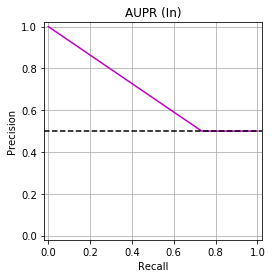

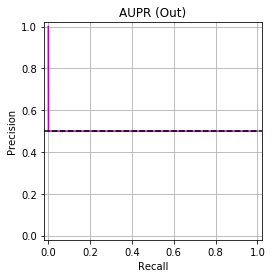

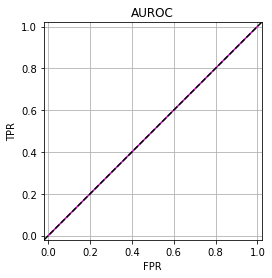

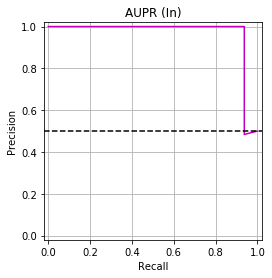

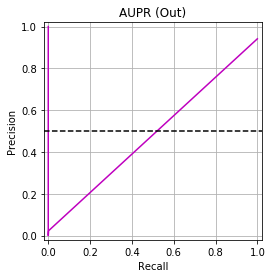

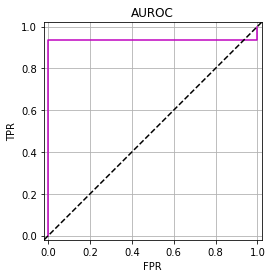

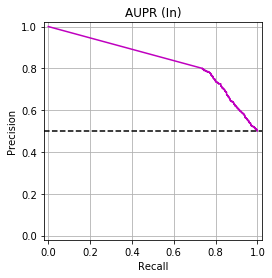

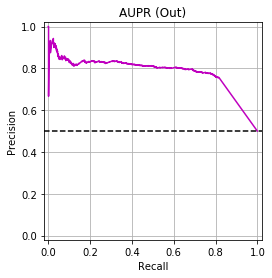

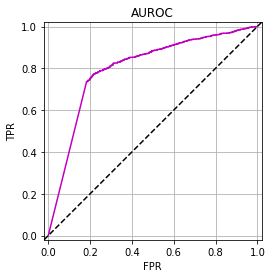

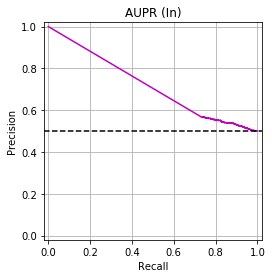

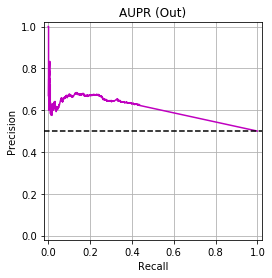

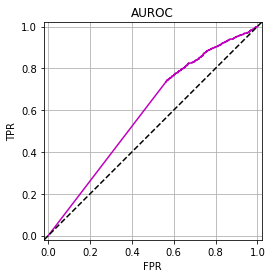

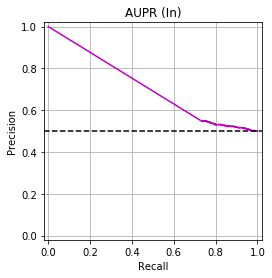

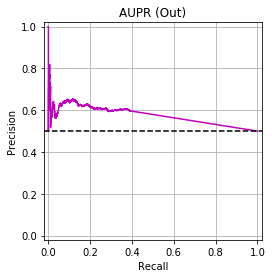

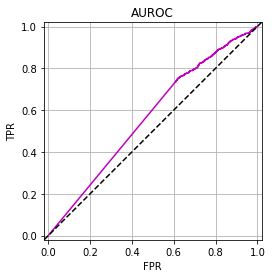

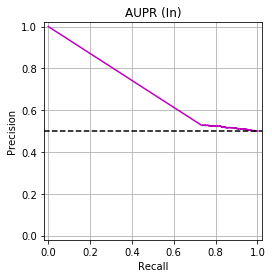

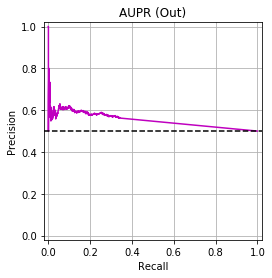

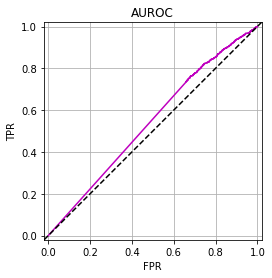

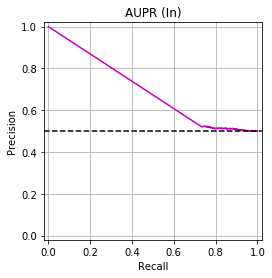

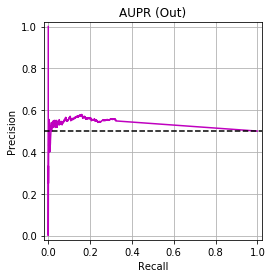

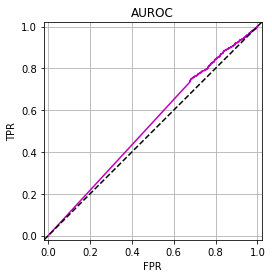

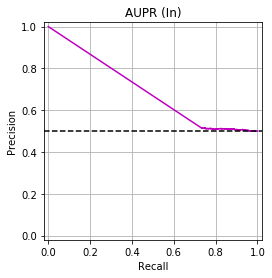

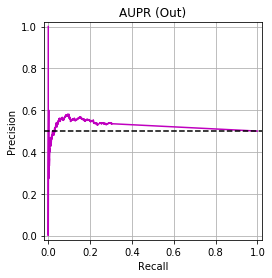

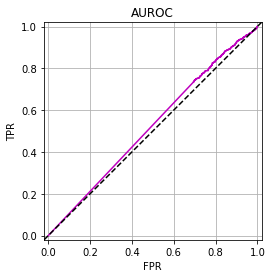

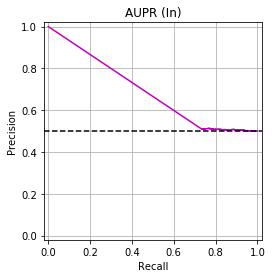

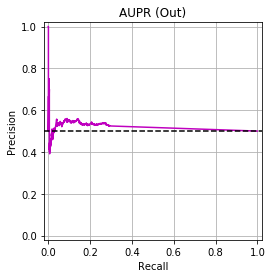

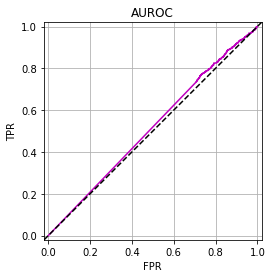

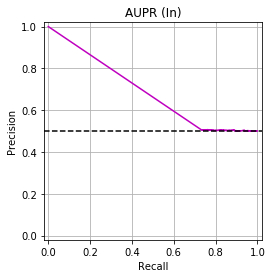

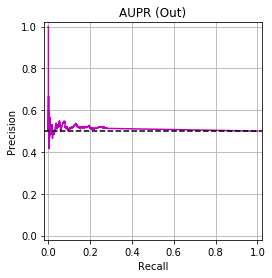

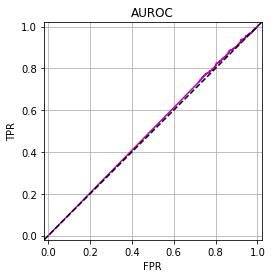

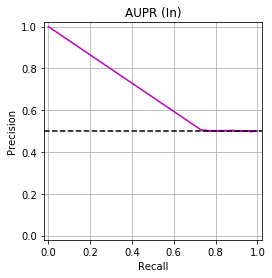

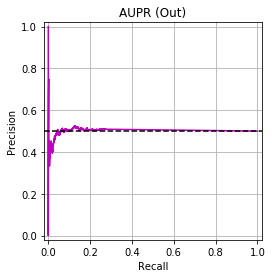

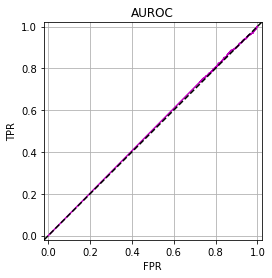

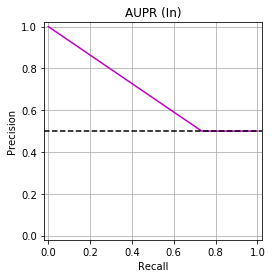

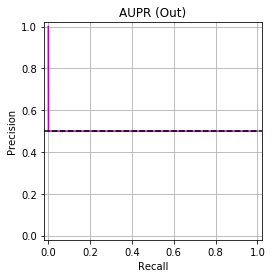

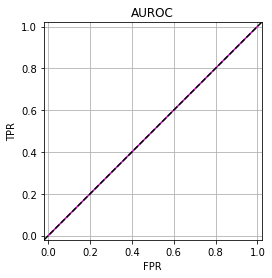

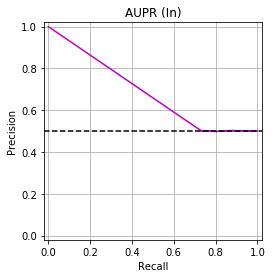

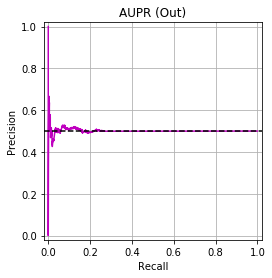

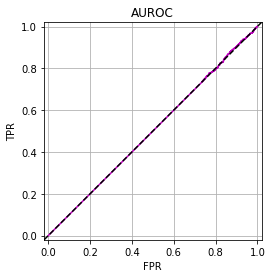

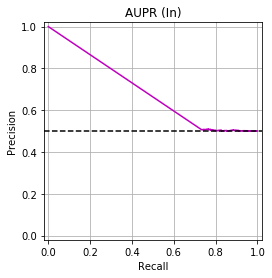

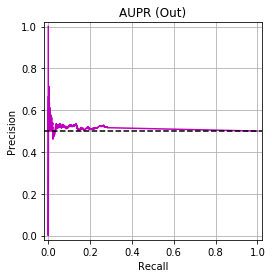

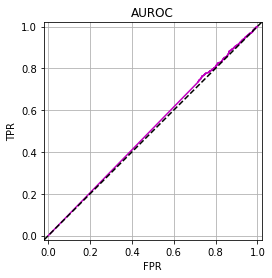

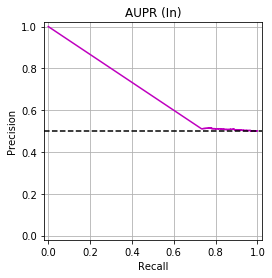

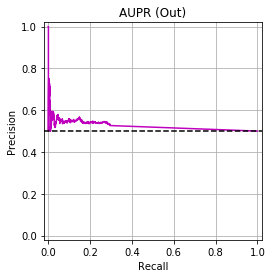

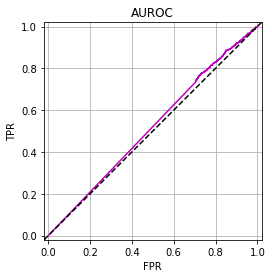

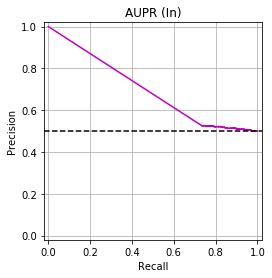

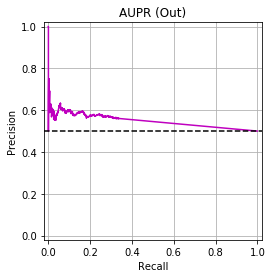

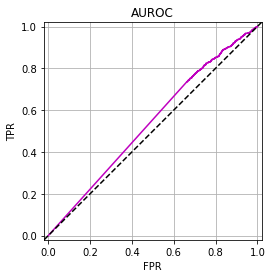

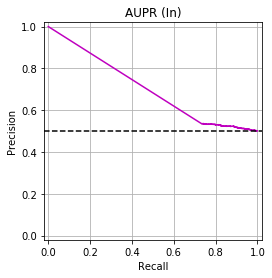

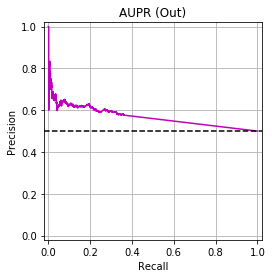

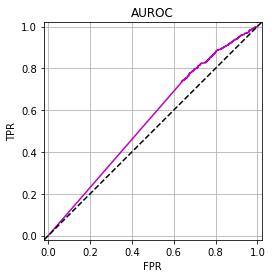

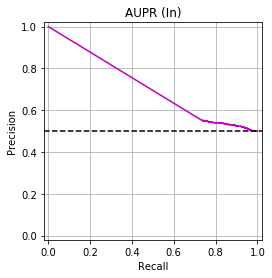

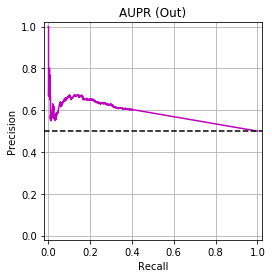

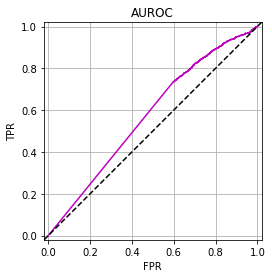

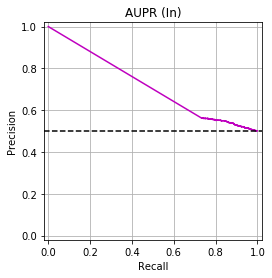

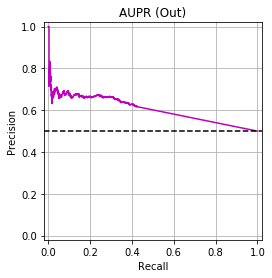

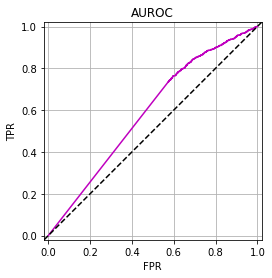

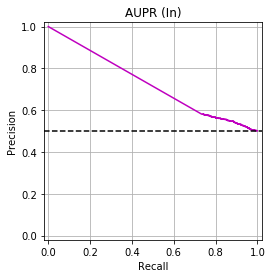

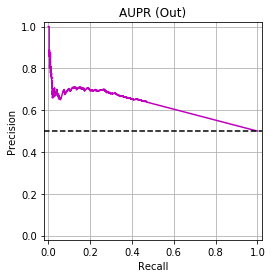

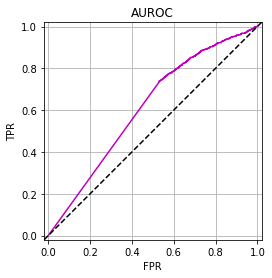

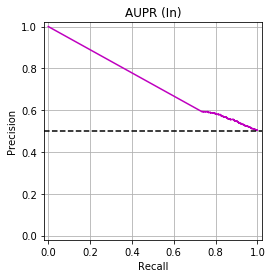

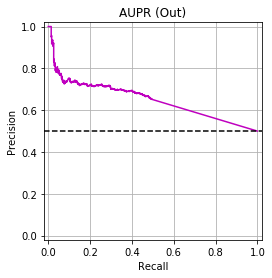

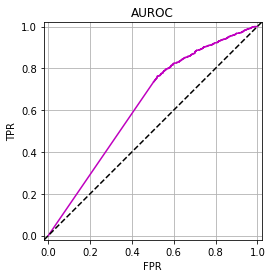

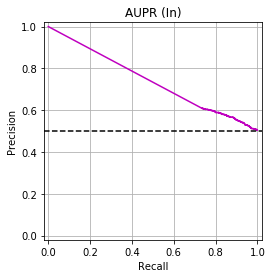

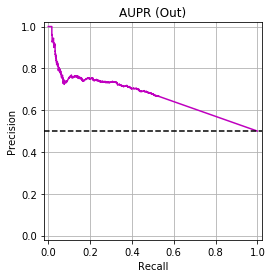

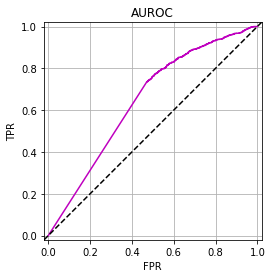

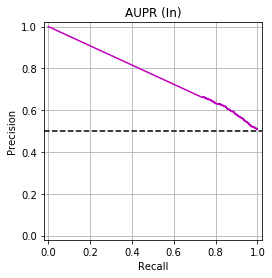

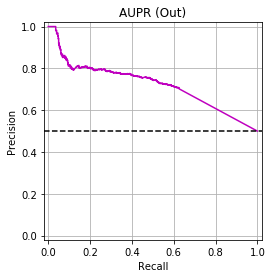

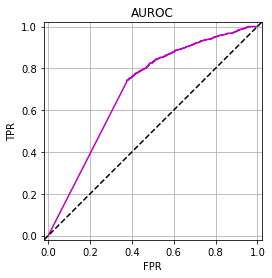

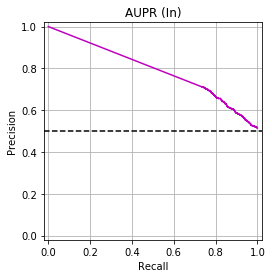

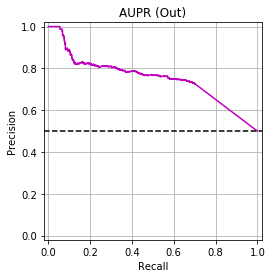

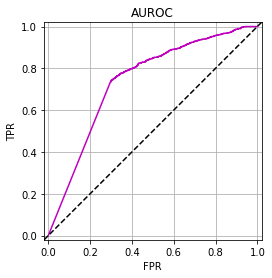

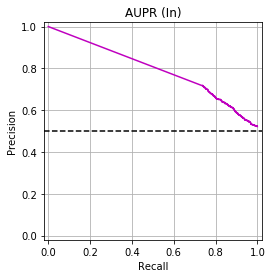

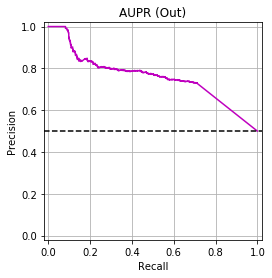

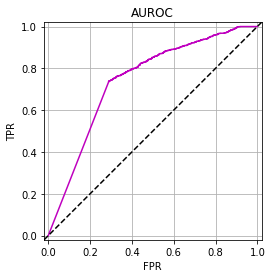

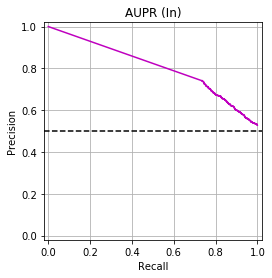

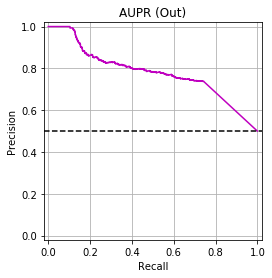

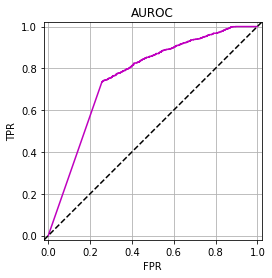

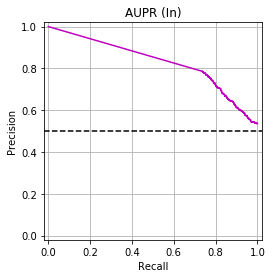

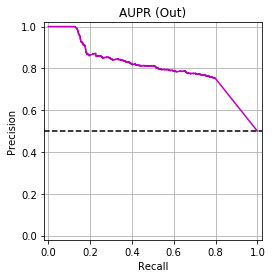

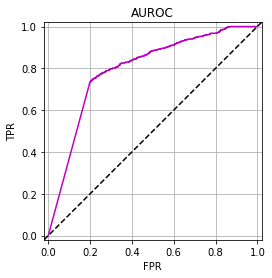

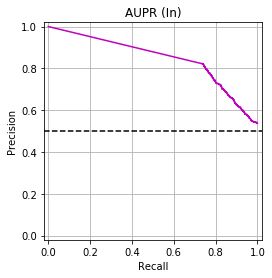

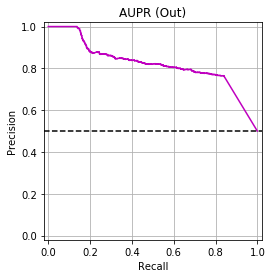

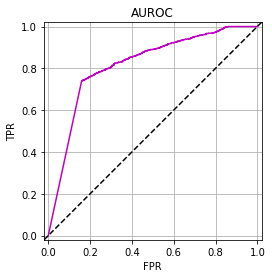

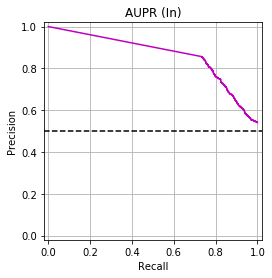

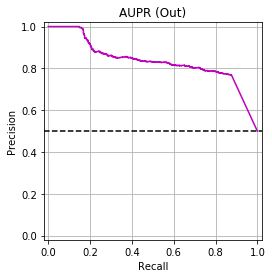

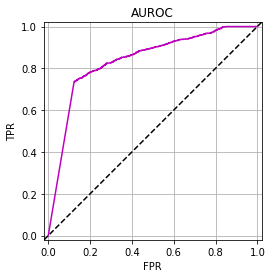

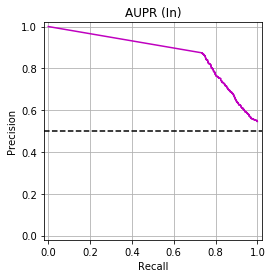

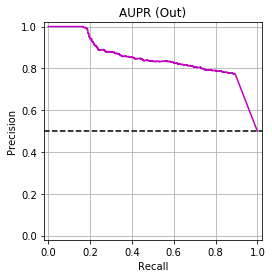

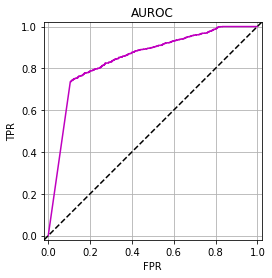

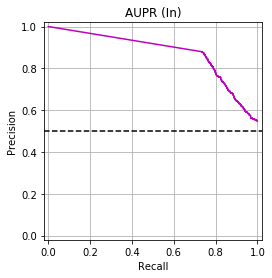

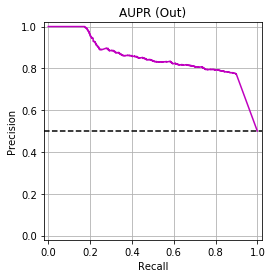

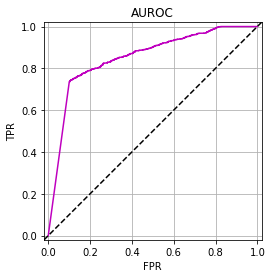

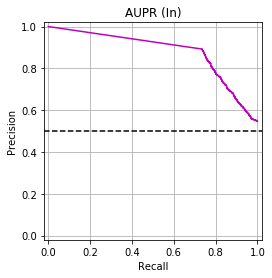

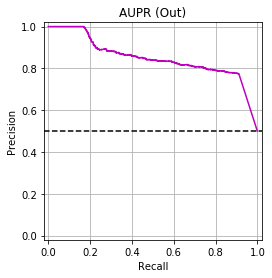

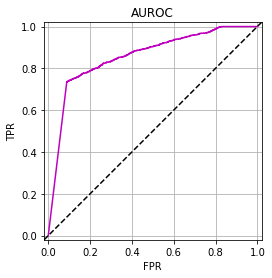

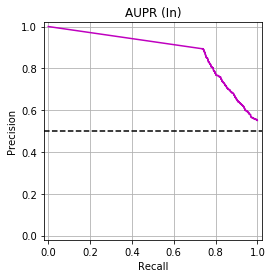

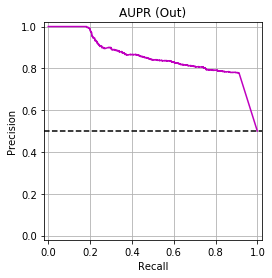

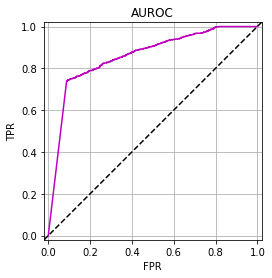

In [17]:
def G_p(ob, p):
    temp = ob.detach()
    
    temp = temp**p
    temp = temp.reshape(temp.shape[0],temp.shape[1],-1)
    temp = ((torch.matmul(temp,temp.transpose(dim0=2,dim1=1)))).sum(dim=2) 
    temp = (temp.sign()*torch.abs(temp)**(1/p)).reshape(temp.shape[0],-1)
    
    return temp

adjust = "bright"

if adjust == 'bright':
    adjust_scale = [1]
    adjust_scale += list(np.arange(0,20,1)/10)
    adjust_scale += list(np.arange(20,80,5)/10)


detector = Detector()
detector.compute_minmaxs(data_train,POWERS=range(1,11))

detector.compute_test_deviations(POWERS=range(1,11))

for idx, ood in enumerate(loaders):  
    import log
    logger = log.setup_logger(seed, str(adjust_scale[idx]))
    print("-------------------------")
    print("IDX: ", idx)
    detector.compute_ood_deviations(logger, list(ood), adjust_scale[idx], POWERS=range(1,11))